In [22]:
import numpy as np
import jax.numpy as jnp
from jax import grad, vmap
from matplotlib import pyplot as plt

In [53]:
def f(x):
    return x**2 - x

### Gradients (derivatives)

- Let
  $$
  f(x) = x^2 - x
  $$

- By calculus class, 08:00, day one:
  $$
  f'(x) = 2x - 1
  $$


In [ ]:
df = grad(f)
xs = np.random.normal(size=10)
for x in xs:
    assert np.allclose([df(x) for x in xs], [2 * x - 1 for x in xs])

### Numpy, JAX-style

JAX can only differentiate functions defined in terms of its own primitive functions.

NumPy's library of mathematical functions are reimplemented differentiably in `jax.numpy`. The convention is to use `jnp` as an alias for this module.

In [ ]:
def f(x):
    return np.cos(2 * x) - x


try:
    grad(f)(0.5)
except Exception as e:
    print(f"Exception!\n\n{type(e)}\n\n{e}")

Exception!

<class 'jax.errors.TracerArrayConversionError'>

The numpy.ndarray conversion method __array__() was called on traced array with shape float32[]
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError


In [ ]:
def f(x):
    return jnp.cos(2 * x) - x


try:
    grad(f)(0.5)
    print("Success!")
except Exception as e:
    print(f"Exception!\n{e}")

Success!


### Vectorization with `vmap`

- Apply a function to an array entrywise.

- Save yourself a loop/comprehension.

In [ ]:
assert np.allclose(vmap(f)(xs), [f(x) for x in xs])
assert np.allclose(vmap(fprime)(xs), [fprime(x) for x in xs])
assert np.allclose(vmap(fprime)(xs), 2 * xs - 1)

### Gradient descent

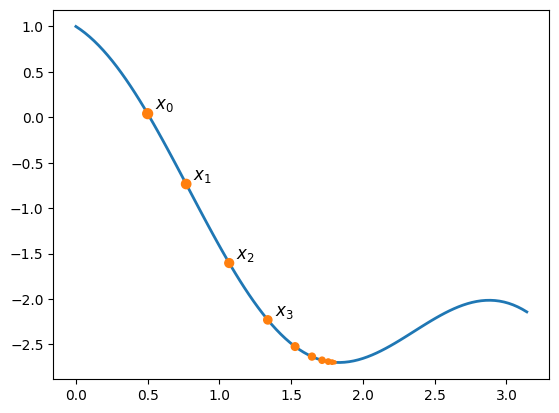

In [126]:
def f(x):
    return jnp.cos(2 * x) - x


df = grad(f)

x = 0.5
lr = 0.1
xs = [x]
for _ in range(10):
    x = x - lr * df(x)
    xs.append(x.item())

grid = np.linspace(0, np.pi, 100)
plt.plot(grid, f(grid), lw=2, zorder=-1)
ys = f(jnp.array(xs))
plt.scatter(xs, ys, c="C1", s=[50 * (1 - i / 10) for i, _ in enumerate(xs)])
for i in range(4):
    plt.annotate(f"$x_{i}$", (xs[i] + 0.05, ys[i] + 0.05), fontsize=12)

You can vectorize gradient descent to descend from multiple starting points concurrently.

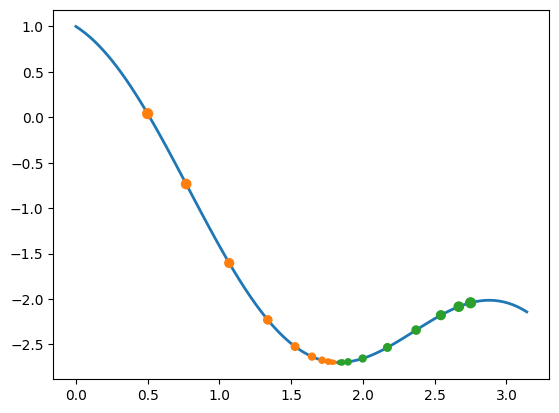

In [123]:
def f(x):
    return jnp.cos(2 * x) - x


df = grad(f)

x = jnp.array([0.5, 2.75])
lr = jnp.array([0.1, 0.2])
xs = [x]
for _ in range(10):
    x = x - lr * vmap(df)(x)
    xs.append(x)

xs = np.array(xs)
grid = np.linspace(0, np.pi, 100)
plt.plot(grid, f(grid), lw=2, zorder=-1)
for j in range(2):
    ys = f(xs[:, j])
    plt.scatter(
        xs[:, j], ys, c=f"C{j + 1}", s=[50 * (1 - i / 10) for i, _ in enumerate(xs)]
    )